## loading packages

In [1]:
import scanpy as sc
import warnings
import pandas as pd
import numpy as np
from scipy.sparse import block_diag

import matplotlib.pyplot as plt
import seaborn as sns

import os
from sklearn.decomposition import (
    PCA,
)
from sklearn.metrics import adjusted_rand_score 

import scipy.sparse as sp
warnings.filterwarnings("ignore")

In [2]:
os.environ["R_HOME"] = "/home/lxx/.conda/envs/r4Base/lib/R"
os.environ["R_USER"] = "/home/lxx/.local/lib/python3.9/site-packages/rpy2"

### ======== use the spCLUE package =========
import spCLUE
spCLUE.fix_seed(0)

## loading data

In [3]:
dlpfcs = [151507, 151669, 151673]
dlpfcs = [str(x + y) for x in dlpfcs for y in range(4)]

adata_s = []
batch_list = []
for i, name in enumerate(dlpfcs):
    print(f"|================== Current slice: {name} ===============|")
    adata = sc.read_h5ad(f"../dataset/DLPFC/{name}.h5ad")
    adata.var_names_make_unique()
    if isinstance(adata.X, sp.csr_matrix):
        adata.X = adata.X.toarray()
    adata = spCLUE.preprocess(adata)
    adata_s.append(adata)
    batch_list += [i] * adata.shape[0]

batch_list = np.array(batch_list)
adata = sc.concat(adata_s)

|================== Current slice: 151507 ===============|
normalized data ---------------->
|================== Current slice: 151508 ===============|
normalized data ---------------->
|================== Current slice: 151509 ===============|
normalized data ---------------->
|================== Current slice: 151510 ===============|
normalized data ---------------->
|================== Current slice: 151669 ===============|
normalized data ---------------->
|================== Current slice: 151670 ===============|
normalized data ---------------->
|================== Current slice: 151671 ===============|
normalized data ---------------->
|================== Current slice: 151672 ===============|
normalized data ---------------->
|================== Current slice: 151673 ===============|
normalized data ---------------->
|================== Current slice: 151674 ===============|
normalized data ---------------->
|================== Current slice: 151675 ===============|
normalized 

In [4]:
adata.obsm["X_pca"] = PCA(n_components=200, random_state=0).fit_transform(adata.X)

# spatial graph
g_spatial_list = []
for adata_cur in adata_s:
    g_spatial = spCLUE.prepare_graph(adata_cur, "spatial")
    g_spatial_list.append(g_spatial)
g_spatial = block_diag(g_spatial_list)

# expression graph
g_expr_list = []
for adata_cur in adata_s:
    g_expr = spCLUE.prepare_graph(adata_cur, "expr")
    g_expr_list.append(g_expr)
g_expr = block_diag(g_expr_list)

graph_dict = {"spatial": g_spatial, "expr": g_expr}

create adjacent matrix from spatial idx --------------->
create knn graph ---->
spatial knn graph created ----<
create adjacent matrix from spatial idx --------------->
create knn graph ---->
spatial knn graph created ----<
create adjacent matrix from spatial idx --------------->
create knn graph ---->
spatial knn graph created ----<
create adjacent matrix from spatial idx --------------->
create knn graph ---->
spatial knn graph created ----<
create adjacent matrix from spatial idx --------------->
create knn graph ---->
spatial knn graph created ----<
create adjacent matrix from spatial idx --------------->
create knn graph ---->
spatial knn graph created ----<
create adjacent matrix from spatial idx --------------->
create knn graph ---->
spatial knn graph created ----<
create adjacent matrix from spatial idx --------------->
create knn graph ---->
spatial knn graph created ----<
create adjacent matrix from spatial idx --------------->
create knn graph ---->
spatial knn graph create

In [5]:
n_clusters = 7

spCLUE_model = spCLUE.spCLUE(
    adata.obsm["X_pca"],
    graph_dict,
    n_clusters,
    batch_list,
    batch_train=True
)
_, adata.obsm["spCLUE"] = spCLUE_model.trainBatch()
adata.obs["batch_name"] = batch_list
adata.obs["batch_name"] = adata.obs["batch_name"].astype("category")

Training Start =========================>


 20%|██        | 101/500 [00:11<00:42,  9.34it/s]

epoch 100: 0.44


 40%|████      | 201/500 [00:21<00:32,  9.34it/s]

epoch 200: 0.34


 60%|██████    | 301/500 [00:32<00:21,  9.34it/s]

epoch 300: 0.34


 80%|████████  | 401/500 [00:42<00:10,  9.34it/s]

epoch 400: 0.36


100%|██████████| 500/500 [00:53<00:00,  9.39it/s]

epoch 500: 0.36
Training Finished =================<


## clustering

In [6]:
cluster_method = "mclust"

spCLUE.clustering(adata,
                         n_clusters,
                         key='spCLUE',
                         cluster_methods=cluster_method)
spCLUE.batch_refine_label(adata, key="mclust", batch_key="batch_name")

R[write to console]: Package 'mclust' version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



array(['4', '1', '6', ..., '3', '0', '4'], dtype='<U1')

In [7]:
adata = adata[adata.obs["Region"].notna()]

ari = adjusted_rand_score(adata.obs["Region"], adata.obs["mclust_refined"])
print(f"ARI of DLPFC (12 slices) is: {ari:.4f}")

ARI of DLPFC (12 slices) is: 0.4329


## Visualization

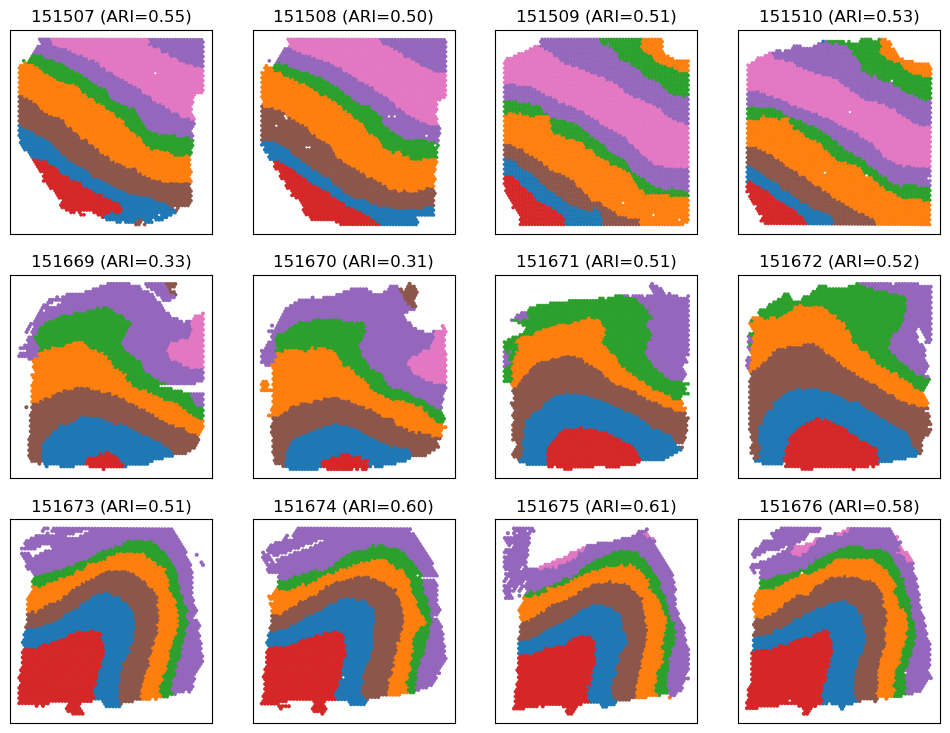

In [8]:
fig, axes = plt.subplots(3, 4, figsize=(12, 9))

tmp = sns.color_palette("tab10")
color_palette = {str(i):tmp[i] for i in range(n_clusters)}

for i in range(12):
    ax = axes[i // 4][i % 4]
    cur = adata[adata.obs["batch_name"] == i]
    cur.obsm["spatial"] = cur.obsm["spatial"] * np.array([1, -1])
    cur_ari = adjusted_rand_score(cur.obs["Region"], cur.obs["mclust_refined"])
    sc.pl.embedding(cur, basis="spatial", color="mclust_refined", palette=color_palette, ax=ax, show=False, legend_loc=None)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(f"{dlpfcs[i]} (ARI={cur_ari:.2f})")